In [1]:
import xnet
import json
import glob
import util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from igraph import *
from scipy.stats import pearsonr
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
from util import save,load
from util import get_attr_pacs,get_pac_list,get_pacs_paper_published

In [2]:
from numpy.random import RandomState

random_state = RandomState()

In [3]:
attr_pacs = get_attr_pacs()
pac_list = get_pac_list()

def get_in(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=IN)
    n_neighbors = len(p_neighbors)
    return n_neighbors

def get_out(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=OUT)
    n_neighbors = len(p_neighbors)
    return n_neighbors

def get_freq_of(data,get_freq,delta,filename):

	history = defaultdict(lambda:defaultdict(lambda:0))

	year_begin = 1986
	year_end = 2006

	for i,year in enumerate(range(year_begin,year_end+1)):
		print("current year %d" % year)
		subset = data.vs.select(year_ge=year,year_le=year+delta)
		subgraph = data.subgraph(subset)
		for paper in subgraph.vs:
			authors_idxs = paper['authors_idxs'].split(',')
			value = get_freq(paper,subgraph)
			for author in authors_idxs:
				history[author][year+delta] += value
		save(history,filename)

	return history

In [4]:
authors_out = load('data/authors_out_freq.json')
authors_in = load('data/authors_in_freq.json') # citações

In [5]:
history_out_filename = 'data/authors_pac_out_2lvls_2multi.json'
history_in_filename = 'data/authors_pac_in_2lvls_2multi.json'

In [6]:
history_out = load(history_out_filename)
authors_out_div = util.authors_metric(history_out,util.get_div) # diversidade das publicações citadas (author out)
save(authors_out_div,'data/authors_out_div.json')
history_in = load(history_in_filename)
authors_in_div = util.authors_metric(history_in,util.get_div) # diversidade das publicações que citam o autor (author in)
save(authors_in_div,'data/authors_in_div.json')

In [7]:
'''
autores válidos seguindo critério frouxo
'''
def read_valid_authors():
    import glob
    name_to_authors = dict()
    files = glob.glob('valid_authors_min_criteria_*.txt')
    for valid_authors_file in files:
        valid_authors = open(valid_authors_file,'r').read().split("\n")[:-1]
        name_to_authors[valid_authors_file[:-4]] = valid_authors
    return name_to_authors

In [8]:
def get_temporal_series(valid_authors,data,min_year):
    Y = []
    for author in valid_authors:
        history = data[author]
        y = []
        old_year = 0
        for year in range(1995,2011):
            try:
                value = history[str(year)]
            except:
                value = 0
            if year >= min_year:
                y.append(value)
        Y.append(np.asarray(y))
    Y = np.asarray(Y)
    return Y

In [9]:
files_valid_authors = read_valid_authors()
files = list(files_valid_authors.keys())
temporal_series_div_out = dict()
temporal_series_div_in = dict()
temporal_series_in = dict()
for file,valid_authors in files_valid_authors.items():
    temporal_series_div_out[file] = get_temporal_series(valid_authors,authors_out_div,1995)
    temporal_series_div_in[file] = get_temporal_series(valid_authors,authors_in_div,1995)
    temporal_series_in[file] = get_temporal_series(valid_authors,authors_in,1995)

In [10]:
def delta_temporal_series(X,delta):
    Y = []
    for x in X:
        y = []
        for i in range(len(x)-delta):
            y.append(x[i+delta]-x[i])
        Y.append(np.asarray(y))
    Y = np.asarray(Y)
    return Y

In [11]:
temporal_series_delta_in = dict()
for file in files:
    temporal_series_delta_in[file] = delta_temporal_series(temporal_series_in[file],1)

In [12]:
def shuffle_data(X,N):
    
    total = np.zeros(X.shape)
    idxs = np.arange(X.shape[1])
    for i in range(N):
        for j in range(X.shape[0]):
            random_state.shuffle(idxs)
            total[j] += X[j][idxs]
    total /= N
    return total

In [13]:
temporal_series_in_shuffled = dict()
temporal_series_delta_in_shuffled = dict()
temporal_series_div_out_shuffled = dict()
temporal_series_div_in_shuffled = dict()
iters = 1000
for file in files:
    temporal_series_in_shuffled[file] = shuffle_data(temporal_series_in[file],iters)
    temporal_series_delta_in_shuffled[file] = shuffle_data(temporal_series_delta_in[file],iters)
    temporal_series_div_out_shuffled[file] = shuffle_data(temporal_series_div_out[file],iters)
    temporal_series_div_in_shuffled[file] = shuffle_data(temporal_series_div_in[file],iters)

In [14]:
from scipy import stats

def corr_temporal_series(temporal_x,temporal_y,shuffled_x,shuffled_y,title,lag,delta=1):
    X = []
    shuffled_X = []
    for x,y,x2,y2 in zip(temporal_x,temporal_y,shuffled_x,shuffled_y):
        if lag == 0:
            corr = pearsonr(x[delta:],y)[0]
            shuffled_corr = pearsonr(x2[delta:],y2)[0]
        else:
            corr = pearsonr(x[delta:-lag],y[lag:])[0]
            shuffled_corr = pearsonr(x2[delta:-lag],y2[lag:])[0]
        
        X.append(corr)    
        shuffled_X.append(shuffled_corr)
    
    shuffled_X = np.asarray(shuffled_X)
    
    plt.title(title)
    plt.xlim(-1,1)
    plt.hist(X,bins=np.linspace(-1,1,50),alpha=0.6,density=True)
#     plt.hist(shuffled_X,bins=np.linspace(-1,1,50),color='red',alpha=0.2)

    x = np.linspace(-1,1, 100)
    kde = stats.gaussian_kde(shuffled_X[~np.isnan(shuffled_X)])
    y = kde(x)
    plt.plot(x,y,color='red')
    plt.savefig('temporal_series_data/'+title+'.pdf')
    plt.clf()
    return X

In [15]:
corr = dict()
for file in files:
    corr[file] = defaultdict(lambda:defaultdict(lambda:None))
    for lag in [0,1,2,3]:
        l = corr_temporal_series(temporal_series_div_in[file],temporal_series_in[file],
                          temporal_series_div_in_shuffled[file],temporal_series_in_shuffled[file],
                          'div in - in - pearson - lag %d\n'%lag+file,lag,delta=0)
        corr[file]['div in - in'][lag] = l
        l = corr_temporal_series(temporal_series_div_in[file],temporal_series_delta_in[file],
                          temporal_series_div_in_shuffled[file],temporal_series_delta_in_shuffled[file],
                          'div in - delta in - pearson - lag %d\n'%lag+file,lag)
        corr[file]['div in - delta in'][lag] = l
        l = corr_temporal_series(temporal_series_div_out[file],temporal_series_in[file],
                          temporal_series_div_out_shuffled[file],temporal_series_in_shuffled[file],
                          'div out - in - pearson - lag %d\n'%lag+file,lag,delta=0)
        corr[file]['div out - in'][lag] = l
        l = corr_temporal_series(temporal_series_div_out[file],temporal_series_delta_in[file],
                          temporal_series_div_out_shuffled[file],temporal_series_delta_in_shuffled[file],
                          'div out - delta in - pearson - lag %d\n'%lag+file,lag)
        corr[file]['div out - delta in'][lag] = l


        l = corr_temporal_series(temporal_series_in[file],temporal_series_in[file],
                         temporal_series_in_shuffled[file],temporal_series_in_shuffled[file],
                         'in - in - pearson - lag %d\n'%lag+file,lag,delta=0)
        corr[file]['in - in'][lag] = l
        l = corr_temporal_series(temporal_series_in[file],temporal_series_delta_in[file],
                         temporal_series_in_shuffled[file],temporal_series_delta_in_shuffled[file],
                         'in - delta in - pearson - lag %d\n'%lag+file,lag,delta=1)
        corr[file]['in - delta in']

/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInp

<Figure size 432x288 with 0 Axes>

In [16]:
for file,corr_pairs in corr.items():
    for pair,corrs in corr_pairs.items():
        for i in range(1,4):
            
#             heatmap, xedges, yedges = np.histogram2d(corrs[0], corrs[1], bins=50)
#             extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#             plt.imshow(heatmap.T, extent=extent, origin='lower')
            plt.scatter(corrs[0],corrs[i],alpha=0.4,s=3,rasterized=True)
            plt.xlim(-1,1)
            plt.ylim(-1,1)
            plt.title(pair+" - lag 0 vs lag %d"%i)
            plt.xlabel("lag 0") 
            plt.ylabel("lag %d"%i)
            plt.tight_layout()
            plt.savefig('temporal_series_data/'+'pearson_corr_lag_0_lag_%s_%d_%s.pdf'%(pair,i,file))
            plt.close()

In [17]:
def get_freq_of_future(data,get_freq,delta,filename):

	history = defaultdict(lambda:defaultdict(lambda:0))

	year_begin = 1986
	year_end = 2007

	for i,year in enumerate(range(year_begin,year_end+1)):
		print("current year %d" % year)
		subset = data.vs.select(year_ge=year,year_le=year+delta)
		subgraph = data.subgraph(subset)
		for paper in subgraph.vs:
			authors_idxs = paper['authors_idxs'].split(',')
			value = get_freq(paper,subgraph)
			for author in authors_idxs:
				history[author][year] += value
		save(history,filename)

	return history

In [18]:
data = xnet.xnet2igraph('data/citation_network_ge1985_pacs.xnet')

In [19]:
#future_citations1 = get_freq_of_future(data,get_in,0,'data/future_citations1.json')
#future_citations2 = get_freq_of_future(data,get_in,1,'data/future_citations2.json')
#future_citations3 = get_freq_of_future(data,get_in,2,'data/future_citations3.json')

In [20]:
future_citations1 = load('data/future_citations1.json')
future_citations2 = load('data/future_citations2.json')
future_citations3 = load('data/future_citations3.json')

In [21]:
files_valid_authors = read_valid_authors()
files = list(files_valid_authors.keys())
temporal_series_future_1 = dict()
temporal_series_future_2 = dict()
temporal_series_future_3 = dict()
print(files)
for file,valid_authors in files_valid_authors.items():
    temporal_series_future_1[file] = get_temporal_series(valid_authors,future_citations1,1995)
    temporal_series_future_2[file] = get_temporal_series(valid_authors,future_citations2,1995)
    temporal_series_future_3[file] = get_temporal_series(valid_authors,future_citations3,1995)

['valid_authors_min_criteria_in_out_10_16', 'valid_authors_min_criteria_in_out_1_10', 'valid_authors_min_criteria_in_out_25_16']


In [22]:
temporal_series_future_1_shuffled = dict()
temporal_series_future_2_shuffled = dict()
temporal_series_future_3_shuffled = dict()
iters = 1000

for file in files:
    temporal_series_future_1_shuffled[file] = shuffle_data(temporal_series_future_1[file],iters)
    temporal_series_future_2_shuffled[file] = shuffle_data(temporal_series_future_2[file],iters)
    temporal_series_future_3_shuffled[file] = shuffle_data(temporal_series_future_3[file],iters)

In [23]:
corr_future = dict()
for file in files:
    corr_future[file] = defaultdict(lambda:defaultdict(lambda:None))
    l = corr_temporal_series(temporal_series_div_in[file],temporal_series_future_1[file],
                    temporal_series_div_in_shuffled[file],temporal_series_future_1_shuffled[file],
                    'div in - future 1 - pearson - lag %d\n'%lag+file,lag=1,delta=0)
    l = corr_temporal_series(temporal_series_div_in[file],temporal_series_future_2[file],
                    temporal_series_div_in_shuffled[file],temporal_series_future_2_shuffled[file],
                    'div in - future 2 - pearson - lag %d\n'%lag+file,lag=1,delta=0)
    l = corr_temporal_series(temporal_series_div_in[file],temporal_series_future_3[file],
                    temporal_series_div_in_shuffled[file],temporal_series_future_3_shuffled[file],
                    'div in - future 3 - pearson - lag %d\n'%lag+file,lag=1,delta=0)

    corr_future[file] = defaultdict(lambda:defaultdict(lambda:None))
    l = corr_temporal_series(temporal_series_in[file],temporal_series_future_1[file],
                    temporal_series_in_shuffled[file],temporal_series_future_1_shuffled[file],
                    'in - future 1 - pearson - lag %d\n'%lag+file,lag=1,delta=0)
    l = corr_temporal_series(temporal_series_in[file],temporal_series_future_2[file],
                    temporal_series_in_shuffled[file],temporal_series_future_2_shuffled[file],
                    'in - future 2 - pearson - lag %d\n'%lag+file,lag=1,delta=0)
    l = corr_temporal_series(temporal_series_in[file],temporal_series_future_3[file],
                    temporal_series_in_shuffled[file],temporal_series_future_3_shuffled[file],
                    'in - future 3 - pearson - lag %d\n'%lag+file,lag=1,delta=0)

/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/carol_mb/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInp

<Figure size 432x288 with 0 Axes>

In [24]:
file = 'valid_authors_min_criteria_in_out_25_16'
l = corr_temporal_series(temporal_series_div_in[file],temporal_series_delta_in[file],
                          temporal_series_div_in_shuffled[file],temporal_series_delta_in_shuffled[file],
                          'div in - delta in - pearson - lag %d\n'%lag+file,lag)
print(len(l))
valid_authors = files_valid_authors[file]
print(len(valid_authors))
authors_valid = []
for author,corr in zip(valid_authors,l):
    if corr >= 0.5:
        authors_valid.append(1)
    else:
        authors_valid.append(0)

622
622


<Figure size 432x288 with 0 Axes>

In [25]:
def get_metric_temporal_serie(valid_authors, metric,value):
    history = [0 for i in range(16)]
    history = np.asarray(history,dtype=np.float)
    count = 0
    for author in valid_authors:
        if author == value:
            history += np.asarray(metric[author],dtype=np.float)
            count += 1
    
    history = history/count
    return history

In [26]:
x = list(range(1995,2011))

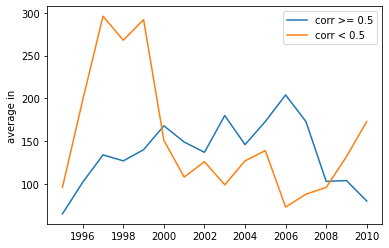

In [27]:
average_in_ge05 = get_metric_temporal_serie(authors_valid,temporal_series_in[file],1)
average_in_l05 = get_metric_temporal_serie(authors_valid,temporal_series_in[file],0)
plt.plot(x,average_in_ge05,label='corr >= 0.5')
plt.plot(x,average_in_l05,label='corr < 0.5')
plt.legend()
plt.ylabel('average in')
plt.savefig('temporal_series_data/div in - delta in - lag 3 - 23_16/average_in.pdf')

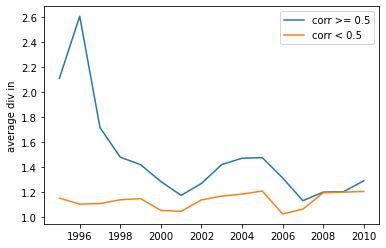

In [28]:
average_div_in_ge05 = get_metric_temporal_serie(authors_valid,temporal_series_div_in[file],1)
average_div_in_l05 = get_metric_temporal_serie(authors_valid,temporal_series_div_in[file],0)
plt.plot(x,average_div_in_ge05,label='corr >= 0.5')
plt.plot(x,average_div_in_l05,label='corr < 0.5')
plt.legend()
plt.ylabel('average div in')
plt.savefig('temporal_series_data/div in - delta in - lag 3 - 23_16/average_div_in.pdf')

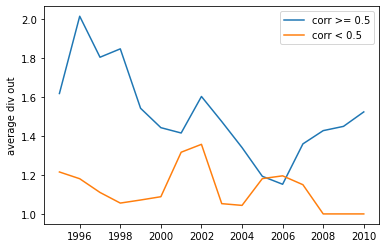

In [29]:
average_div_out_ge05 = get_metric_temporal_serie(authors_valid,temporal_series_div_out[file],1)
average_div_out_l05 = get_metric_temporal_serie(authors_valid,temporal_series_div_out[file],0)
plt.plot(x,average_div_out_ge05,label='corr >= 0.5')
plt.plot(x,average_div_out_l05,label='corr < 0.5')
plt.legend()
plt.ylabel('average div out')
plt.savefig('temporal_series_data/div in - delta in - lag 3 - 23_16/average_div_out.pdf')